# Домашнее задание: Multi-Branch MLP для Wine Quality

**Цель**: Реализовать multi-branch модель и добиться F1 score ≥ 40%

**Задачи**:
1. Реализовать три типа блоков: Bottleneck, Inverted Bottleneck, Regular
2. Создать Multi-Branch архитектуру
3. Использовать weighted loss для борьбы с дисбалансом классов
4. Подобрать оптимальные гиперпараметры (глубина, ширина, lr, оптимизатор)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import sys
sys.path.append('../../lesson3/seminar')
from wine_quality_data import WineQualityDataModule
from lightning_module import BaseLightningModule
from utils import set_seed
from pytorch_lightning import Trainer

sns.set_style('whitegrid')
set_seed(42)

## 1. Загрузка и анализ данных

Загрузим Wine Quality датасет и проанализируем распределение классов.

In [2]:
# Загружаем данные
dm = WineQualityDataModule(batch_size=128)
dm.setup()

print(f'Train samples: {len(dm.train_dataset)}')
print(f'Val samples: {len(dm.val_dataset)}')
print(f'Input dim: {dm.input_dim}')
print(f'Num classes: {dm.n_classes}')

Train samples: 1279
Val samples: 320
Input dim: 11
Num classes: 6


### 1.1. Анализ дисбаланса классов

Проанализируйте распределение классов и вычислите веса для weighted loss.

In [11]:
dm.train_dataset[100]

(tensor([-0.4759,  0.2923, -0.6872, -0.2499, -0.2342,  1.0385,  0.3817, -0.2351,
         -0.1886, -0.4132, -0.5862]),
 tensor(2))

Class weights: [26.64583333  5.07539683  0.3911315   0.41797386  1.34067086 14.21111111]


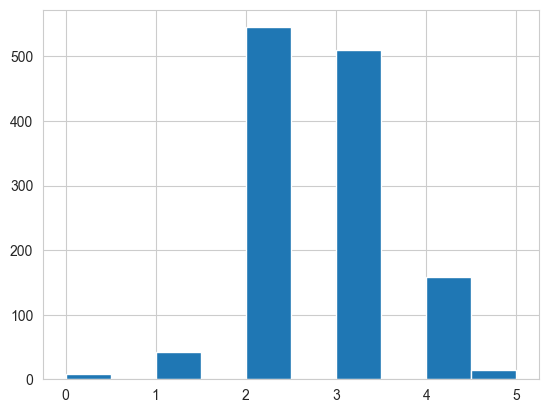

In [16]:
# TODO: Получите метки классов из train_dataset
# Hint: dm.train_dataset[i] возвращает (X, y)
train_labels = []

for i in range(len(dm.train_dataset)):
    _, y = dm.train_dataset[i]
    train_labels.append(y)

train_labels = np.array(train_labels)

# TODO: Постройте гистограмму распределения классов
plt.hist(train_labels)

# TODO: Вычислите веса классов используя compute_class_weight
# Веса должны быть обратно пропорциональны частоте класса (однако это может не работать, поэтому можете подобрать сами)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)  # TODO

print(f'Class weights: {class_weights}')

## 2. Реализация блоков

Реализуйте три типа блоков:
- **Bottleneck**: dim → dim//4 → dim (сужение)
- **Inverted Bottleneck**: dim → dim*4 → dim (расширение)
- **Regular**: dim → hidden_dim → dim (обычный)

In [17]:
from abc import ABC, abstractmethod

class BaseMLPBlock(nn.Module, ABC):
    """Базовый класс для MLP блока"""
    def __init__(self, dim, activation='gelu', dropout=0.0):
        super().__init__()
        self.dim = dim
        self.activation = {'relu': nn.ReLU(), 'gelu': nn.GELU(), 'swish': nn.SiLU()}.get(activation, nn.GELU())
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
    
    @abstractmethod
    def forward(self, x):
        pass

class BottleneckBlock(BaseMLPBlock):
    """
    Bottleneck блок: dim → dim//4 → dim
    
    Сужает размерность в 4 раза, затем восстанавливает.
    Использует residual connection для стабильного обучения.
    """
    def __init__(self, dim, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)
        
        # Bottleneck dimension (сужение в 4 раза)
        self.bottleneck_dim = max(dim // 4, 1)
        
        # Линейные слои: dim → bottleneck_dim → dim
        self.fc1 = nn.Linear(self.dim, self.bottleneck_dim)
        self.fc2 = nn.Linear(self.bottleneck_dim, self.dim)
    
    def forward(self, x):
        identity = x
        
        # Bottleneck pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)
        
        # Residual connection
        return out + identity

class InvertedBottleneckBlock(BaseMLPBlock):
    """
    Inverted Bottleneck блок: dim → dim*4 → dim
    
    Расширяет размерность в 4 раза, затем сжимает обратно.
    Использует residual connection для стабильного обучения.
    """
    def __init__(self, dim, expansion_factor=4, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)
        
        # Expanded dimension (расширение в 4 раза)
        self.expanded_dim = dim * expansion_factor
        
        # Линейные слои: dim → expanded_dim → dim
        self.fc1 = nn.Linear(self.dim, self.expanded_dim)
        self.fc2 = nn.Linear(self.expanded_dim, self.dim)
    
    def forward(self, x):
        identity = x
        
        # Inverted bottleneck pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)
        
        # Residual connection
        return out + identity

class RegularBlock(BaseMLPBlock):
    """
    Regular блок: dim → hidden_dim → dim
    
    Обычный двухслойный MLP с residual connection.
    hidden_dim по умолчанию равен dim * 2.
    """
    def __init__(self, dim, hidden_dim=None, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)
        
        # Hidden dimension (по умолчанию в 2 раза больше)
        self.hidden_dim = hidden_dim if hidden_dim else dim * 2
        
        # Линейные слои: dim → hidden_dim → dim
        self.fc1 = nn.Linear(self.dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.dim)
    
    def forward(self, x):
        identity = x
        
        # Regular pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)
        
        # Residual connection
        return out + identity

# Тестируем блоки
print('✓ Блоки успешно определены!')
print()

# Проверим размерности
test_x = torch.randn(4, 64)
print('Тестирование блоков с размерностью 64:')
print(f'  Input shape: {test_x.shape}')

bottleneck = BottleneckBlock(64)
print(f'  BottleneckBlock output: {bottleneck(test_x).shape}')

inverted = InvertedBottleneckBlock(64)
print(f'  InvertedBottleneckBlock output: {inverted(test_x).shape}')

regular = RegularBlock(64)
print(f'  RegularBlock output: {regular(test_x).shape}')

# Подсчитаем параметры
print()
print('Количество параметров:')
print(f'  BottleneckBlock: {sum(p.numel() for p in bottleneck.parameters()):,}')
print(f'  InvertedBottleneckBlock: {sum(p.numel() for p in inverted.parameters()):,}')
print(f'  RegularBlock: {sum(p.numel() for p in regular.parameters()):,}')

✓ Блоки успешно определены!

Тестирование блоков с размерностью 64:
  Input shape: torch.Size([4, 64])
  BottleneckBlock output: torch.Size([4, 64])
  InvertedBottleneckBlock output: torch.Size([4, 64])
  RegularBlock output: torch.Size([4, 64])

Количество параметров:
  BottleneckBlock: 2,128
  InvertedBottleneckBlock: 33,088
  RegularBlock: 16,576


## 3. Multi-Branch модель

Реализуйте модель с тремя параллельными ветками.

**Архитектура**:
```
         Input
           |
      projection
           |
      ┌────┼────┐
      │    │    │
  Bottleneck  Inverted  Regular
   Branch      Branch    Branch
      │    │    │
      └────┼────┘
           |
      Concatenate/Sum
           |
      projection
           |
        Output
```

In [18]:
class MultiBranchMLP(nn.Module):
    """
    Multi-Branch MLP с тремя параллельными ветками.
    
    Args:
        input_dim: размерность входа
        hidden_dim: размерность скрытых слоев
        output_dim: размерность выхода (число классов)
        num_blocks: количество блоков в каждой ветке
        dropout: вероятность dropout
        combine_mode: способ объединения веток ('concat' или 'sum')
    """
    def __init__(
        self,
        input_dim,
        hidden_dim,
        output_dim,
        num_blocks=4,
        dropout=0.1,
        combine_mode='concat'
    ):
        super().__init__()
        self.output_dim = output_dim
        self.combine_mode = combine_mode
        
        # TODO: Входная проекция
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # TODO: Создайте три ветки (branches)
        # Branch 1: num_blocks блоков BottleneckBlock
        self.bottleneck_branch = nn.ModuleList(
            [BottleneckBlock(hidden_dim, dropout=dropout) for _ in range(num_blocks)]
        )
        # Branch 2: num_blocks блоков InvertedBottleneckBlock
        self.inverted_branch = nn.ModuleList(
            [InvertedBottleneckBlock(hidden_dim, dropout=dropout) for _ in range(num_blocks)]
        )
        # Branch 3: num_blocks блоков RegularBlock
        self.regular_branch = nn.ModuleList(
            [RegularBlock(hidden_dim, dropout=dropout) for _ in range(num_blocks)]
        )
        # Используйте nn.ModuleList
        
        # self.bottleneck_branch = ...
        # self.inverted_branch = ...
        # self.regular_branch = ...
        
        # TODO: Выходная проекция
        # Если combine_mode == 'concat', то вход будет hidden_dim * 3
        # Если combine_mode == 'sum', то вход будет hidden_dim
        if self.combine_mode == 'concat':
            out_in_dim = hidden_dim * 3
        elif self.combine_mode == 'sum':
            out_in_dim = hidden_dim
        else:
            raise ValueError('combine_mode должен быть \'concat\' или \'sum\'')
        self.output_proj = nn.Linear(out_in_dim, output_dim)
        
        pass  # TODO: удалите pass после реализации
    
    def forward(self, x):
        # TODO: Реализуйте forward pass
        # 1. Входная проекция
        x = self.input_proj(x)
        # 2. Пропустите через каждую ветку
        b = x
        for block in self.bottleneck_branch:
            b = block(b)

        i = x
        for block in self.inverted_branch:
            i = block(i)
        
        r = x
        for block in self.regular_branch:
            r = block(r)
        # 3. Объедините результаты (concat или sum)
        if self.combine_mode == 'concat':
            h = torch.cat([b, i, r], dim=1)
        else:
            h = b + i + r
        # 4. Выходная проекция
        out = self.output_proj(h)
        return out

print('Multi-Branch модель определена!')

Multi-Branch модель определена!


## 4. Код обучение

In [ ]:
def train_model(
    model,
    dm,
    class_weights=None,
    max_epochs=50,
    lr=1e-3,
    optimizer_type='adam'
):
    """
    Обучает модель с weighted loss.
    
    Args:
        model: модель для обучения
        dm: DataModule
        class_weights: веса классов для weighted loss (numpy array или None)
        max_epochs: количество эпох
        lr: learning rate
        optimizer_type: тип оптимизатора ('adam', 'adamw', 'sgd')
    
    Returns:
        dict с метриками
    """
    # TODO: Создайте loss function
    # Если class_weights не None, используйте nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
    # Иначе используйте обычный nn.CrossEntropyLoss()
    loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))    

    lightning_model = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type=optimizer_type,
        learning_rate=lr,
        task_type='multiclass'
    )
    
    trainer = Trainer(
        max_epochs=max_epochs,
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=True,
        enable_model_summary=False
    )
    trainer.fit(lightning_model, dm)
    
    metrics = trainer.callback_metrics
    return {
        'val_acc': metrics.get('val_accuracy', 0).item(),
        'val_f1': metrics.get('val_f1_macro', 0).item()
    }

## 5. Итоговая модель

Обучите модель с лучшими гиперпараметрами.

In [ ]:
# TODO: Обучите итоговую модель с лучшими гиперпараметрами
final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=64,
    output_dim=dm.n_classes,
    num_blocks=2,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=1e-2,
    optimizer_type='adam'
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score: {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1641, f1_macro=0.1110


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.2569, f1_macro=0.1534


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.2969, f1_macro=0.1887


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.3314, f1_macro=0.2075


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.3438, f1_macro=0.2133


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.3384, f1_macro=0.2147


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.3552, f1_macro=0.2252


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.3650, f1_macro=0.2329


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.3647, f1_macro=0.2351


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.3638, f1_macro=0.2341


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.3727, f1_macro=0.2390


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.3766, f1_macro=0.2403


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.3716, f1_macro=0.2395


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.3687, f1_macro=0.2382


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.3706, f1_macro=0.2389


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.3740, f1_macro=0.2412


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.3804, f1_macro=0.2450


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.3845, f1_macro=0.2466


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.3911, f1_macro=0.2503


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.3933, f1_macro=0.2528


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.3942, f1_macro=0.2543


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.3936, f1_macro=0.2548


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.3951, f1_macro=0.2549


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.3973, f1_macro=0.2564


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.4016, f1_macro=0.2587


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.4048, f1_macro=0.2601


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.4069, f1_macro=0.2620


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.4086, f1_macro=0.2634


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.4078, f1_macro=0.2632


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.4107, f1_macro=0.2645


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.4112, f1_macro=0.2653


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.4095, f1_macro=0.2656


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.4121, f1_macro=0.2663


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.4129, f1_macro=0.2669


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.4172, f1_macro=0.2690


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.4214, f1_macro=0.2712


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.4203, f1_macro=0.2710


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.4203, f1_macro=0.2714


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.4225, f1_macro=0.2726


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.4236, f1_macro=0.2735


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.4230, f1_macro=0.2730


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.4256, f1_macro=0.2745


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.4265, f1_macro=0.2750


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.4279, f1_macro=0.2758


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.4301, f1_macro=0.2774


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.4314, f1_macro=0.2781


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.4297, f1_macro=0.2771


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.4284, f1_macro=0.2763


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.4274, f1_macro=0.2751


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.4232, f1_macro=0.2726


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49: accuracy=0.4200, f1_macro=0.2710


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50: accuracy=0.4159, f1_macro=0.2690


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51: accuracy=0.4151, f1_macro=0.2683


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52: accuracy=0.4137, f1_macro=0.2675


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53: accuracy=0.4126, f1_macro=0.2672


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54: accuracy=0.4117, f1_macro=0.2667


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55: accuracy=0.4116, f1_macro=0.2662


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56: accuracy=0.4117, f1_macro=0.2661


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57: accuracy=0.4116, f1_macro=0.2657


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58: accuracy=0.4118, f1_macro=0.2658


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59: accuracy=0.4117, f1_macro=0.2654


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60: accuracy=0.4128, f1_macro=0.2659


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61: accuracy=0.4127, f1_macro=0.2655


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62: accuracy=0.4135, f1_macro=0.2658


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63: accuracy=0.4140, f1_macro=0.2658


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64: accuracy=0.4147, f1_macro=0.2660


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65: accuracy=0.4153, f1_macro=0.2661


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66: accuracy=0.4162, f1_macro=0.2665


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67: accuracy=0.4162, f1_macro=0.2662


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68: accuracy=0.4170, f1_macro=0.2667


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69: accuracy=0.4181, f1_macro=0.2674


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70: accuracy=0.4187, f1_macro=0.2677


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71: accuracy=0.4192, f1_macro=0.2679


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72: accuracy=0.4205, f1_macro=0.2688


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73: accuracy=0.4218, f1_macro=0.2694


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74: accuracy=0.4227, f1_macro=0.2697


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75: accuracy=0.4229, f1_macro=0.2698


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76: accuracy=0.4233, f1_macro=0.2698


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77: accuracy=0.4240, f1_macro=0.2700


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78: accuracy=0.4243, f1_macro=0.2700


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79: accuracy=0.4252, f1_macro=0.2704


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80: accuracy=0.4253, f1_macro=0.2704


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81: accuracy=0.4261, f1_macro=0.2709


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82: accuracy=0.4262, f1_macro=0.2709


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83: accuracy=0.4269, f1_macro=0.2713


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84: accuracy=0.4277, f1_macro=0.2717


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85: accuracy=0.4284, f1_macro=0.2720


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86: accuracy=0.4292, f1_macro=0.2726


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87: accuracy=0.4303, f1_macro=0.2733


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88: accuracy=0.4310, f1_macro=0.2738


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89: accuracy=0.4320, f1_macro=0.2744


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90: accuracy=0.4329, f1_macro=0.2749


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91: accuracy=0.4339, f1_macro=0.2755


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92: accuracy=0.4353, f1_macro=0.2764


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93: accuracy=0.4360, f1_macro=0.2768


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94: accuracy=0.4372, f1_macro=0.2774


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95: accuracy=0.4379, f1_macro=0.2777


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96: accuracy=0.4388, f1_macro=0.2782


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97: accuracy=0.4397, f1_macro=0.2788


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98: accuracy=0.4407, f1_macro=0.2794


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: accuracy=0.4415, f1_macro=0.2799

=== Итоговые результаты ===
F1 score: 0.2799
Accuracy: 0.4415


In [21]:
# TODO: Обучите итоговую модель с лучшими гиперпараметрами
final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=128,
    output_dim=dm.n_classes,
    num_blocks=4,
    dropout=0.1,
    combine_mode='sum'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=1e-2,
    optimizer_type='adam'
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score: {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1562, f1_macro=0.1054


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1458, f1_macro=0.1077


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.1328, f1_macro=0.1107


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.2253, f1_macro=0.1544


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.2578, f1_macro=0.1675


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.2683, f1_macro=0.1821


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.2592, f1_macro=0.1820


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.2708, f1_macro=0.1874


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.2869, f1_macro=0.2001


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.3013, f1_macro=0.2083


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.3073, f1_macro=0.2121


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.3157, f1_macro=0.2162


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.3259, f1_macro=0.2209


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.3388, f1_macro=0.2272


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.3465, f1_macro=0.2302


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.3447, f1_macro=0.2286


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.3536, f1_macro=0.2336


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.3569, f1_macro=0.2356


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.3589, f1_macro=0.2358


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.3655, f1_macro=0.2406


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.3700, f1_macro=0.2423


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.3750, f1_macro=0.2448


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.3788, f1_macro=0.2476


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.3812, f1_macro=0.2489


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.3802, f1_macro=0.2494


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.3791, f1_macro=0.2497


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.3823, f1_macro=0.2516


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.3879, f1_macro=0.2544


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.3919, f1_macro=0.2562


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.3968, f1_macro=0.2588


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.3992, f1_macro=0.2598


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.4015, f1_macro=0.2605


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.4057, f1_macro=0.2629


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.4087, f1_macro=0.2645


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.4132, f1_macro=0.2671


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.4134, f1_macro=0.2674


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.4136, f1_macro=0.2675


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.4148, f1_macro=0.2679


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.4172, f1_macro=0.2691


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.4141, f1_macro=0.2682


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.4154, f1_macro=0.2688


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.4138, f1_macro=0.2687


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.4141, f1_macro=0.2686


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.4142, f1_macro=0.2683


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.4174, f1_macro=0.2697


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.4190, f1_macro=0.2704


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.4186, f1_macro=0.2708


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.4200, f1_macro=0.2718


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.4225, f1_macro=0.2730


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.4258, f1_macro=0.2745


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49: accuracy=0.4280, f1_macro=0.2757


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50: accuracy=0.4304, f1_macro=0.2772


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51: accuracy=0.4328, f1_macro=0.2785


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52: accuracy=0.4341, f1_macro=0.2791


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53: accuracy=0.4319, f1_macro=0.2784


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54: accuracy=0.4252, f1_macro=0.2752


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55: accuracy=0.4191, f1_macro=0.2721


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56: accuracy=0.4186, f1_macro=0.2714


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57: accuracy=0.4188, f1_macro=0.2703


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58: accuracy=0.4134, f1_macro=0.2679


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59: accuracy=0.4070, f1_macro=0.2646


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60: accuracy=0.4017, f1_macro=0.2616


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61: accuracy=0.3978, f1_macro=0.2599


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62: accuracy=0.3938, f1_macro=0.2567


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63: accuracy=0.3907, f1_macro=0.2550


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64: accuracy=0.3880, f1_macro=0.2527


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65: accuracy=0.3848, f1_macro=0.2514


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66: accuracy=0.3818, f1_macro=0.2498


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67: accuracy=0.3790, f1_macro=0.2475


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68: accuracy=0.3754, f1_macro=0.2458


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69: accuracy=0.3733, f1_macro=0.2447


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70: accuracy=0.3730, f1_macro=0.2446


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71: accuracy=0.3723, f1_macro=0.2443


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72: accuracy=0.3678, f1_macro=0.2425


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73: accuracy=0.3674, f1_macro=0.2421


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74: accuracy=0.3651, f1_macro=0.2410


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75: accuracy=0.3642, f1_macro=0.2408


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76: accuracy=0.3640, f1_macro=0.2410


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77: accuracy=0.3641, f1_macro=0.2410


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78: accuracy=0.3637, f1_macro=0.2407


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79: accuracy=0.3630, f1_macro=0.2402


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80: accuracy=0.3622, f1_macro=0.2400


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81: accuracy=0.3636, f1_macro=0.2405


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82: accuracy=0.3650, f1_macro=0.2411


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83: accuracy=0.3646, f1_macro=0.2408


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84: accuracy=0.3632, f1_macro=0.2403


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85: accuracy=0.3641, f1_macro=0.2405


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86: accuracy=0.3632, f1_macro=0.2402


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87: accuracy=0.3634, f1_macro=0.2400


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88: accuracy=0.3645, f1_macro=0.2406


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89: accuracy=0.3652, f1_macro=0.2411


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90: accuracy=0.3643, f1_macro=0.2408


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91: accuracy=0.3640, f1_macro=0.2405


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92: accuracy=0.3639, f1_macro=0.2406


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93: accuracy=0.3633, f1_macro=0.2404


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94: accuracy=0.3643, f1_macro=0.2409


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95: accuracy=0.3637, f1_macro=0.2405


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96: accuracy=0.3619, f1_macro=0.2396


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97: accuracy=0.3624, f1_macro=0.2400


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98: accuracy=0.3632, f1_macro=0.2403


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: accuracy=0.3649, f1_macro=0.2412

=== Итоговые результаты ===
F1 score: 0.2412
Accuracy: 0.3649


In [32]:
# TODO: Обучите итоговую модель с лучшими гиперпараметрами
final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=256,
    output_dim=dm.n_classes,
    num_blocks=8,
    dropout=0.2,
    combine_mode='concat',
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=1e-3,                     
    optimizer_type='adamw',
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score: {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.2266, f1_macro=0.1530


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.2500, f1_macro=0.1770


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.3002, f1_macro=0.1890


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.3281, f1_macro=0.2050


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.3398, f1_macro=0.2170


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.3502, f1_macro=0.2197


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.3663, f1_macro=0.2288


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.3798, f1_macro=0.2355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.3821, f1_macro=0.2383


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.3893, f1_macro=0.2407


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.3921, f1_macro=0.2409


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.3861, f1_macro=0.2411


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.3899, f1_macro=0.2444


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.3920, f1_macro=0.2454


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.3942, f1_macro=0.2453


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.3995, f1_macro=0.2482


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.4029, f1_macro=0.2507


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.4048, f1_macro=0.2525


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.4041, f1_macro=0.2535


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.4053, f1_macro=0.2547


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.4084, f1_macro=0.2578


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.4103, f1_macro=0.2590


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.4110, f1_macro=0.2587


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.4133, f1_macro=0.2601


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.4171, f1_macro=0.2617


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.4203, f1_macro=0.2630


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.4205, f1_macro=0.2640


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.4243, f1_macro=0.2661


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.4272, f1_macro=0.2673


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.4281, f1_macro=0.2691


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.4306, f1_macro=0.2709


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.4312, f1_macro=0.2719


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.4329, f1_macro=0.2725


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.4361, f1_macro=0.2745


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.4364, f1_macro=0.2751


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.4367, f1_macro=0.2757


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.4375, f1_macro=0.2766


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.4382, f1_macro=0.2773


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.4409, f1_macro=0.2786


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.4425, f1_macro=0.2796


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.4446, f1_macro=0.2808


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.4474, f1_macro=0.2825


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.4500, f1_macro=0.2840


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.4518, f1_macro=0.2853


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.4545, f1_macro=0.2867


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.4547, f1_macro=0.2871


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.4554, f1_macro=0.2879


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.4566, f1_macro=0.2887


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.4587, f1_macro=0.2902


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.4595, f1_macro=0.2907


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49: accuracy=0.4612, f1_macro=0.2918


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50: accuracy=0.4631, f1_macro=0.2931


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51: accuracy=0.4648, f1_macro=0.2941


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52: accuracy=0.4664, f1_macro=0.2948


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53: accuracy=0.4674, f1_macro=0.2956


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54: accuracy=0.4686, f1_macro=0.2963


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55: accuracy=0.4703, f1_macro=0.2974


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56: accuracy=0.4720, f1_macro=0.2985


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57: accuracy=0.4726, f1_macro=0.2990


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58: accuracy=0.4748, f1_macro=0.3003


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59: accuracy=0.4762, f1_macro=0.3011


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60: accuracy=0.4782, f1_macro=0.3023


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61: accuracy=0.4789, f1_macro=0.3028


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62: accuracy=0.4804, f1_macro=0.3037


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63: accuracy=0.4818, f1_macro=0.3045


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64: accuracy=0.4830, f1_macro=0.3051


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65: accuracy=0.4835, f1_macro=0.3056


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66: accuracy=0.4847, f1_macro=0.3064


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67: accuracy=0.4856, f1_macro=0.3071


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68: accuracy=0.4868, f1_macro=0.3079


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69: accuracy=0.4880, f1_macro=0.3087


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70: accuracy=0.4892, f1_macro=0.3095


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71: accuracy=0.4901, f1_macro=0.3102


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72: accuracy=0.4911, f1_macro=0.3108


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73: accuracy=0.4921, f1_macro=0.3114


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74: accuracy=0.4934, f1_macro=0.3121


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75: accuracy=0.4945, f1_macro=0.3127


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76: accuracy=0.4955, f1_macro=0.3133


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77: accuracy=0.4961, f1_macro=0.3137


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78: accuracy=0.4973, f1_macro=0.3145


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79: accuracy=0.4988, f1_macro=0.3154


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80: accuracy=0.5000, f1_macro=0.3160


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81: accuracy=0.5011, f1_macro=0.3166


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82: accuracy=0.5023, f1_macro=0.3170


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83: accuracy=0.5032, f1_macro=0.3174


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84: accuracy=0.5040, f1_macro=0.3179


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85: accuracy=0.5049, f1_macro=0.3183


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86: accuracy=0.5055, f1_macro=0.3189


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87: accuracy=0.5066, f1_macro=0.3195


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88: accuracy=0.5077, f1_macro=0.3202


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89: accuracy=0.5084, f1_macro=0.3208


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90: accuracy=0.5092, f1_macro=0.3213


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91: accuracy=0.5101, f1_macro=0.3219


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92: accuracy=0.5108, f1_macro=0.3225


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93: accuracy=0.5114, f1_macro=0.3229


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94: accuracy=0.5121, f1_macro=0.3232


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95: accuracy=0.5128, f1_macro=0.3237


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96: accuracy=0.5135, f1_macro=0.3241


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97: accuracy=0.5141, f1_macro=0.3243


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98: accuracy=0.5146, f1_macro=0.3246


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: accuracy=0.5154, f1_macro=0.3250

=== Итоговые результаты ===
F1 score: 0.3250
Accuracy: 0.5154
